In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import os

from torch.cuda.amp import GradScaler, autocast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')

import ray
from ray import tune, train
from ray.tune import CLIReporter, ExperimentAnalysis
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
from ray.train import Checkpoint
import torch._dynamo
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = True

In [2]:
input_file = r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\LUZ_Daily_Complete.csv'
data = pd.read_csv(input_file)
data = data.fillna(0)


X = data.values

y = data[['GWAP','LWAP']].values


In [3]:
train_size = int(0.6 * len(X))  # 60% for training
val_size = int(0.20 * len(X))   # 20% for validation
test_size = len(X) - train_size - val_size  # Remaining 15% for testing

train_data = X[:train_size]
train_labels = y[:train_size]

val_data = X[train_size:train_size + val_size]
val_labels = y[train_size:train_size + val_size]

test_data = X[train_size + val_size:]
test_labels = y[train_size + val_size:]
seq_len=7
batch_size=64

In [4]:
def classify_features(data):
    minmax_cols = []
    boxcox_cols = []
    yeojohnson_cols = []

    for i in range(data.shape[1]):  # Iterate over columns by index
        col_data = data[:, i]  # Get each column as a separate array
        skewness = skew(col_data)
        kurt = kurtosis(col_data)
        is_positive = np.all(col_data > 0)

        if -1 <= skewness <= 1 and -1 <= kurt <= 1:
            minmax_cols.append(i)  # Add index for MinMax family
        elif is_positive:
            boxcox_cols.append(i)  # Add index for BoxCox family
        else:
            yeojohnson_cols.append(i)  # Add index for YeoJohnson family

    return minmax_cols, boxcox_cols, yeojohnson_cols

minmax_cols, boxcox_cols, yeojohnson_cols = classify_features(X)

transformers = [
    ('minmax', MinMaxScaler(), minmax_cols),
    ('boxcox_minmax', Pipeline([
        ('boxcox', PowerTransformer(method='box-cox', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), boxcox_cols),
    ('yeojohnson_minmax', Pipeline([
        ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), yeojohnson_cols)
]

preprocessor = ColumnTransformer(transformers=transformers)

# Build the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


pipeline.fit(train_data)
transformed_train_data = pipeline.transform(train_data)
transformed_val_data = pipeline.transform(val_data)
transformed_test_data = pipeline.transform(test_data)

minmax_colsy, boxcox_colsy, yeojohnson_colsy = classify_features(y)
transformersy = [
    ('minmax', MinMaxScaler(), minmax_colsy),
    ('boxcox_minmax', Pipeline([
        ('boxcox', PowerTransformer(method='box-cox', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), boxcox_colsy),
    ('yeojohnson_minmax', Pipeline([
        ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), yeojohnson_colsy)
]
preprocessory = ColumnTransformer(transformers=transformersy)

# Build the full pipeline
pipeliney = Pipeline(steps=[
    ('preprocessor', preprocessory)
])
pipeliney.fit(train_labels)

transformed_train_labels = pipeliney.transform(train_labels)
transformed_val_labels = pipeliney.transform(val_labels)
transformed_test_labels = pipeliney.transform(test_labels)


In [5]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len 
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

In [6]:
train_dataset = TimeSeriesDataset(transformed_train_data, transformed_train_labels, seq_len)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(transformed_val_data, transformed_val_labels, seq_len)    
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False) 

test_dataset = TimeSeriesDataset(transformed_test_data, transformed_test_labels, seq_len)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

In [7]:
class LSTMCustomCell(nn.Module):
    def __init__(self, input_size, hidden_size, activation_fn):
        super(LSTMCustomCell, self).__init__()
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        
        # Combine all gate matrices into one large matrix for efficiency
        self.W_ih = nn.Linear(input_size, 4 * hidden_size, bias=False)
        self.W_hh = nn.Linear(hidden_size, 4 * hidden_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        
    def forward(self, x, hidden):
        h, c = hidden
        
        # Optimized matrix multiplication and bias addition
        gates = self.W_ih(x) + self.W_hh(h) + self.bias
        
        # Split into 4 gate vectors
        i_gate, f_gate, o_gate, g_gate = torch.chunk(gates, 4, dim=1)
        
        # Sigmoid activations for gates
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        o_gate = torch.sigmoid(o_gate)
        
        # Apply the custom activation function for the cell gate
        g_gate = self.activation_fn(g_gate)
        
        # Compute the new cell state
        c_next = f_gate * c + i_gate * g_gate
        
        # Compute the new hidden state using the custom activation function
        h_next = o_gate * self.activation_fn(c_next)
        
        return h_next, c_next

In [8]:
class LSTMCustom(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, activation_fn=torch.tanh, batch_first=False):
        super(LSTMCustom, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.activation_fn = activation_fn
        self.batch_first = batch_first
        
        # Create a list of LSTM cells
        self.cells = nn.ModuleList([LSTMCustomCell(input_size if i == 0 else hidden_size, hidden_size, activation_fn) for i in range(num_layers)])
        
    def forward(self, x, hidden=None):
        # Determine the correct input shape
        if self.batch_first:
            batch_size, seq_len, _ = x.size()
            x = x.transpose(0, 1)  # Convert to (seq_len, batch_size, input_size) for processing
        else:
            seq_len, batch_size, _ = x.size()
        
        if hidden is None:
            # Initialize hidden and cell states with zeros
            h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        else:
            h, c = hidden
        
        outputs = []
        
        # Iterate over each time step
        for t in range(seq_len):
            x_t = x[t, :, :]  # Input at time step t
            for i, cell in enumerate(self.cells):

                h[i], c[i] = cell(x_t, (h[i], c[i]))
                x_t = h[i]  # Pass hidden state to the next layer

            outputs.append(h[-1].unsqueeze(0))  # Collect output from the last layer
        
        # Stack the outputs across time steps
        outputs = torch.cat(outputs, dim=0)
        
        # Convert output back to (batch_size, seq_len, hidden_size) if batch_first is True
        if self.batch_first:
            outputs = outputs.transpose(0, 1)
        
        # Return outputs and the last hidden and cell states
        return outputs, (torch.stack(h), torch.stack(c))



In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,activation_fn):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = LSTMCustom(input_size, hidden_size, num_layers, activation_fn, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        # Forward propagate LSTM
        out, _ = self.lstm(x)

        out = self.fc(out[:, -1, :])  # Take the output from the last time step


        return out

In [234]:
#model = torch.compile(model)

In [10]:
# Define model parameters
input_size = train_data.shape[1]  # Number of features
hidden_size = 128
output_size = train_labels.shape[1]  # Number of output features
num_layers = 2
activation_fn = torch.relu
model = LSTMModel(input_size, hidden_size,output_size, num_layers,activation_fn).to(device)
epoch=100
# Define loss function and optimizer
criterion = nn.MSELoss()  # Use MSE loss for regression tasks
optimizer = optim.AdamW(list(model.parameters()), lr=1e-4, weight_decay=1e-5)


In [11]:
scaler = torch.amp.GradScaler()

def train(model, dataloader, device, optimizer, criterion):
    model.train()
    total_loss = 0.0  # Initialize total loss to 0

    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Check for NaN values in inputs
        
        
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        
        # Check for NaN values in outputs
        
        
        loss = criterion(outputs, targets)
        
        
        
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item() * inputs.size(0)

    # Return the average loss over all batches
    return total_loss / len(train_dataloader.dataset)
        
       

In [12]:
@torch.no_grad()
def evaluate(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0.0  # Initialize total loss
    

    for i, (inputs, target) in enumerate(dataloader):  # Use `test_dataloader`
        inputs, target = inputs.to(device), target.to(device)

        # Forward pass
        outputs = model(inputs)
        
        predictions = outputs.to(device)  
    
        loss = criterion(predictions, target)

        # Accumulate the loss
        total_loss += loss.item() * inputs.size(0)

    # Return the average loss over all batches
    
    return total_loss/len(dataloader.dataset)


In [13]:
def load_data():
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
    return train_dataloader, val_dataloader

In [14]:
def train_lstm(config,epoch):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = LSTMModel(input_size, config["hidden_size"], output_size, config["num_layers"],activation_fn).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(list(model.parameters()), lr=config["lr"], weight_decay=config["weight_decay"])
    
    

    train_dataloader, val_dataloader = load_data()
    for e in range(epoch):  # Replace with your actual number of epochs
        train_loss = train(model, train_dataloader, device, optimizer, criterion)
        val_loss = evaluate(model, val_dataloader, device, criterion)
        

        # Report the results
        session.report(  # Highlighted change
            {"loss": val_loss} # Highlighted change
        )


In [15]:
search_space = {
    "hidden_size": tune.choice([50, 100, 200]),
    "num_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "weight_decay": tune.loguniform(1e-6, 1e-3)
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(
    metric_columns=["loss", "training_iteration"]
)

def trial_dirname_creator(trial):
    return f"trial_{trial.trial_id}"

In [16]:
ray.shutdown()  # Shutdown any existing Ray instances
ray.init(ignore_reinit_error=True)

Usage stats collection is enabled. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2024-10-24 23:08:13,306	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.20
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [17]:
tune.run(
    tune.with_parameters(train_lstm, epoch=epoch),
    resources_per_trial={"cpu": 4, "gpu": 1},
    config=search_space,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter,
    verbose=1,
    trial_dirname_creator=trial_dirname_creator
)

2024-10-24 23:08:18,018	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-10-24 23:08:18 (running for 00:00:00.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 4.0/20 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2024-10-24_23-08-10_347821_32244/artifacts/2024-10-24_23-08-18/train_lstm_2024-10-24_23-08-18/driver_artifacts
Number of trials: 10/10 (10 PENDING)
+------------------------+----------+-------+---------------+-------------+--------------+----------------+
| Trial name             | status   | loc   |   hidden_size |          lr |   num_layers |   weight_decay |
|------------------------+----------+-------+---------------+-------------+--------------+----------------|
| train_lstm_ccd7c_00000 | PENDING  |       |            50 | 0.00303588  |            3 |    1.77167e-06 |
| train_lstm_ccd7c_00001 | PENDING  |       |           200 | 0.00993261  |            

2024-10-24 23:09:00,606	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Paulo John Mercado/ray_results/train_lstm_2024-10-24_23-08-18' in 0.0115s.
2024-10-24 23:09:00,610	INFO tune.py:1041 -- Total run time: 42.59 seconds (42.41 seconds for the tuning loop).


== Status ==
Current time: 2024-10-24 23:09:00 (running for 00:00:42.42)
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -16182.412630911005 | Iter 4.000: -1402187.6456199393 | Iter 2.000: -1866305.182472867 | Iter 1.000: -6887259.580624579
Logical resource usage: 4.0/20 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2024-10-24_23-08-10_347821_32244/artifacts/2024-10-24_23-08-18/train_lstm_2024-10-24_23-08-18/driver_artifacts
Number of trials: 10/10 (10 TERMINATED)
+------------------------+------------+-----------------+---------------+-------------+--------------+----------------+-----------------+----------------------+
| Trial name             | status     | loc             |   hidden_size |          lr |   num_layers |   weight_decay |            loss |   training_iteration |
|------------------------+------------+-----------------+---------------+-------------+--------------+----------------+----------------

In [21]:
train_losses = []
val_losses = []
test_losses = []
def run(model, train_dataloader, val_dataloader, test_dataloader, device, epoch,optimizer):

    for epoch in range(epoch):
        
        train_loss = train(model, train_dataloader, device, optimizer, criterion)
        train_losses.append(train_loss)
        val_loss=evaluate(model,val_dataloader,device,criterion)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Val Loss: {val_loss}")
        

        if train_loss < 1e-3 :
            break

In [24]:
epoch=100
run(model, train_dataloader,val_dataloader, test_dataloader, device, epoch,optimizer)

Epoch 1, Training Loss: 0.35611060704266667, Val Loss: 27023.070567499282
Epoch 2, Training Loss: 0.3416177843397012, Val Loss: 64290.04404919991
Epoch 3, Training Loss: 0.3281291240605843, Val Loss: 80591.20858007236
Epoch 4, Training Loss: 0.3144710478815844, Val Loss: 104117.85447075989
Epoch 5, Training Loss: 0.2989988830415943, Val Loss: 126766.85843084635
Epoch 6, Training Loss: 0.2797932606492961, Val Loss: 259990.4709908647
Epoch 7, Training Loss: 0.2545474135336356, Val Loss: 418465.8773688292
Epoch 8, Training Loss: 0.21997605533859846, Val Loss: 698388.240536252
Epoch 9, Training Loss: 0.17131063224544657, Val Loss: 1815302.9679194884
Epoch 10, Training Loss: 0.10405718860175382, Val Loss: 8409335.734778084
Epoch 11, Training Loss: 0.040319181425527185, Val Loss: 27214004.52807455
Epoch 12, Training Loss: 0.06745215908574533, Val Loss: 28788104.31639882
Epoch 13, Training Loss: 0.046496175514780455, Val Loss: 14506093.599998802
Epoch 14, Training Loss: 0.041796312029981283, 

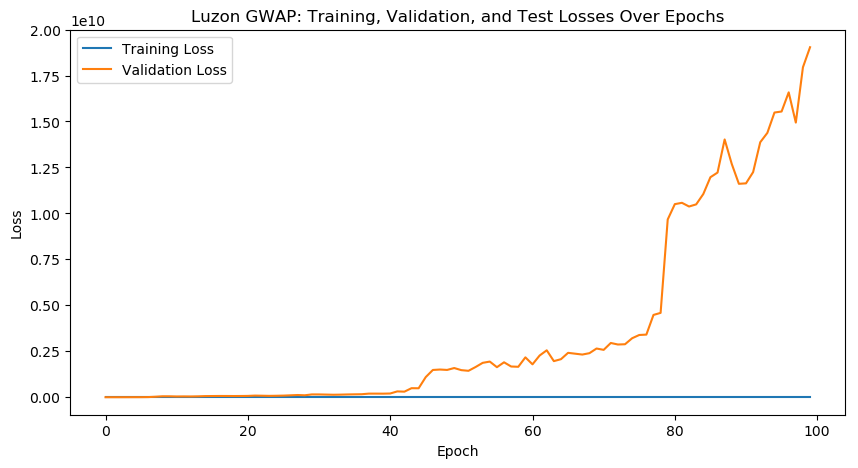

In [256]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Luzon GWAP: Training, Validation, and Test Losses Over Epochs')

plt.show()
